# UTS Machine Learning

## Tugas 2

### Import Library

In [10]:
%pip install -q annoy kagglehub

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


### Get Dataset

In [11]:
path = 'C:\\Users\\ASUS\\.cache\\kagglehub\\datasets\\uciml\\default-of-credit-card-clients-dataset\\versions\\1\\UCI_Credit_Card.csv'

df = pd.read_csv(path)

df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### Preprocessing

In [19]:
# Tangani missing values: numeric -> median, object -> mode
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
# Fill numeric with median (robust to outliers)
for c in num_cols:
    df[c].fillna(df[c].median(), inplace=True)
# Fill categorical with mode
for c in obj_cols:
    if df[c].isnull().any():
        df[c].fillna(df[c].mode().iloc[0], inplace=True)

# Buat fitur baru: rasio antara BALANCE dan PURCHASES (cek nama kolom pada dataset)
# Dataset 'Default of Credit Card Clients' punya kolom seperti 'BILL_AMT1'..'BILL_AMT6' dan 'PAY_AMT1'..; adjust accordingly.
# We'll attempt reasonable columns: 'BALANCE' and 'PURCHASES' if they exist, otherwise create a proxy ratio.
if 'BALANCE' in df.columns and 'PURCHASES' in df.columns:
    df['balance_purchase_ratio'] = df['BALANCE'] / (df['PURCHASES'].replace(0, np.nan))
else:
    # Try using BILL_AMT1 as balance proxy and PAY_AMT1 or 'LIMIT_BAL' as purchase proxy where sensible
    if 'LIMIT_BAL' in df.columns and 'PAY_AMT1' in df.columns:
        df['balance_purchase_ratio'] = df['LIMIT_BAL'] / (df['PAY_AMT1'].replace(0, np.nan))
    else:
        # Fallback: ratio of mean bill amounts to mean payments if available
        bill_cols = [c for c in df.columns if c.startswith('BILL_AMT')]
        pay_cols = [c for c in df.columns if c.startswith('PAY_AMT')]
        if bill_cols and pay_cols:
            df['balance_purchase_ratio'] = df[bill_cols].mean(axis=1) / (df[pay_cols].mean(axis=1).replace(0, np.nan))
        else:
            # If nothing suitable, create a small constant feature of zeros to avoid breaking pipeline
            df['balance_purchase_ratio'] = 0.0
# Replace inf/nan from ratio with large/sentinel values and then median
df['balance_purchase_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['balance_purchase_ratio'].fillna(df['balance_purchase_ratio'].median(), inplace=True)

# Pilih fitur numerik untuk clustering (hindari target kolom jika ada)
exclude = []
possible_targets = ['default.payment.next.month', 'default.payment.next.month'.replace('.', '_')]
for t in possible_targets:
    if t in df.columns:
        exclude.append(t)
# Create numeric dataframe and drop any excluded columns (e.g., target)
num_df = df.select_dtypes(include=[np.number]).drop(columns=[c for c in exclude if c in df.columns])
# IMPORTANT: drop identifier columns that are not features (e.g., 'ID')
if 'ID' in num_df.columns:
    num_df = num_df.drop(columns=['ID'])
# Normalisasi data numerik: gunakan RobustScaler to lessen outlier impact
scaler = RobustScaler()
X_scaled = scaler.fit_transform(num_df)
# Keep feature names for later
feature_names = num_df.columns.tolist()
print('Using features (count):', len(feature_names))
print(feature_names)

Using features (count): 24
['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'balance_purchase_ratio']


C:\Users\ASUS\AppData\Local\Temp\ipykernel_7940\3907140214.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7940\3907140214.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

### Search K value using Elbow

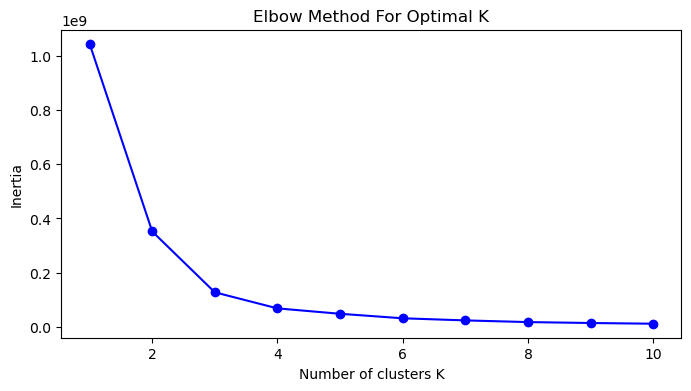

In [13]:
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

### Clustering with K-Means

In [20]:
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)


print("KMeans Silhouette:", silhouette_score(X_scaled, labels_kmeans)) 
print("KMeans Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_kmeans))

KMeans Silhouette: 0.9912020562992758
KMeans Davies-Bouldin: 0.3464522059424104


### Clustering with DBScan

In [21]:
# Pastikan X_scaled tersedia (hasil scaler dari preprocessing).
if 'X_scaled' not in globals():
    raise RuntimeError('X_scaled tidak ditemukan. Jalankan sel preprocessing terlebih dahulu.')

# Hitung distances untuk k = 5 (jarak ke 5th NN) jika belum ada
k_for_dist = 5
try:
    _ = distances  # gunakan existing jika ada
except Exception:
    nn = NearestNeighbors(n_neighbors=k_for_dist).fit(X_scaled)
    dists, _ = nn.kneighbors(X_scaled)
    distances = np.sort(dists[:, -1])

# Kandidat eps berdasarkan persentil (fokus area sebelum lonjakan besar)
percentiles = np.linspace(60, 98, 15)
eps_candidates = np.unique(np.percentile(distances, percentiles))

# min_samples untuk dicoba (baseline 5, beberapa nilai lebih konservatif)
min_samples_list = [5, 8, 10, 15]

results = []
for ms in min_samples_list:
    for eps in eps_candidates:
        db = DBSCAN(eps=float(eps), min_samples=int(ms))
        labels = db.fit_predict(X_scaled)
        n = len(labels)
        n_noise = int((labels == -1).sum())
        noise_ratio = n_noise / max(1, n)
        unique_labels = set(labels)
        n_clusters = len(unique_labels - {-1})
        if n_clusters >= 2:
            try:
                sil = silhouette_score(X_scaled, labels)
            except Exception:
                sil = np.nan
            try:
                dbi = davies_bouldin_score(X_scaled, labels)
            except Exception:
                dbi = np.nan
        else:
            sil = np.nan
            dbi = np.nan
        results.append({'eps': float(eps), 'min_samples': int(ms), 'n_clusters': int(n_clusters), 'noise_ratio': float(noise_ratio), 'silhouette': sil, 'dbi': dbi})

df_res = pd.DataFrame(results)
df_res_sorted = df_res.sort_values(by=['silhouette'], ascending=False, na_position='last')
display(df_res_sorted.head(20))

# Rekomendasi: pilih baris pertama dengan silhouette tidak nan, noise_ratio < 0.5, dan 2<=n_clusters<=15
cand = df_res_sorted[~df_res_sorted['silhouette'].isna()]
cand = cand[(cand['noise_ratio'] < 0.5) & (cand['n_clusters'].between(2, 15))]
if not cand.empty:
    best = cand.iloc[0]
    print('\nRecommended configuration (based on silhouette & reasonable noise/cluster count):')
    print(f"eps = {best['eps']:.4g}, min_samples = {int(best['min_samples'])}\n  n_clusters = {int(best['n_clusters'])}, noise_ratio = {best['noise_ratio']:.3f}, silhouette = {best['silhouette']:.4f}")
else:
    print('\nNo good silhouette-based candidate found. Fallback: eps ~ 0.5, min_samples = 5 (atau 10 jika ingin lebih konservatif).')

print('\nTop candidates per min_samples (by silhouette):')
summary = df_res.groupby('min_samples').apply(lambda g: g.sort_values('silhouette', na_position='last').head(3)).reset_index(drop=True)
display(summary[['min_samples','eps','n_clusters','noise_ratio','silhouette','dbi']])

print('\nCatatan: pilih eps di kiri sebelum lonjakan besar di k-distance plot; min_samples=5 baseline, naikkan ke 8-15 jika ingin cluster lebih ketat.')

,eps,min_samples,n_clusters,noise_ratio,silhouette,dbi
29,10.304830,8,3,0.018167,0.899244,4.673631
44,10.304830,10,3,0.019133,0.879451,2.191694
14,10.304830,5,9,0.015567,0.825826,6.323747
28,6.268228,8,3,0.040933,0.767536,2.498678
42,4.922289,10,2,0.065633,0.743981,1.739787
13,6.268228,5,5,0.037100,0.739657,4.141880
43,6.268228,10,4,0.043400,0.724526,1.663071
12,4.922289,5,10,0.057333,0.693321,3.497532
57,4.922289,15,2,0.070100,0.661980,1.780389
27,4.922289,8,4,0.063333,0.658917,1.725760



Recommended configuration (based on silhouette & reasonable noise/cluster count):
eps = 10.3, min_samples = 8
  n_clusters = 3, noise_ratio = 0.018, silhouette = 0.8992

Top candidates per min_samples (by silhouette):


C:\Users\ASUS\AppData\Local\Temp\ipykernel_7940\3330589104.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df_res.groupby('min_samples').apply(lambda g: g.sort_values('silhouette', na_position='last').head(3)).reset_index(drop=True)


,min_samples,eps,n_clusters,noise_ratio,silhouette,dbi
0,5,2.031648,50,0.308233,-0.416953,2.412803
1,5,2.123708,31,0.287133,-0.381093,2.457174
2,5,2.222033,32,0.265567,-0.351396,2.520664
3,8,2.031648,20,0.329433,-0.338046,2.522117
4,8,2.123708,12,0.307267,-0.303335,2.751103
5,8,2.222033,12,0.285600,-0.264792,2.778774
6,10,2.031648,17,0.339467,-0.294003,2.559140
7,10,2.123708,11,0.315933,-0.222509,2.987447
8,10,2.599413,10,0.222567,-0.165425,2.919089
9,15,2.031648,18,0.359967,-0.332676,2.022043



Catatan: pilih eps di kiri sebelum lonjakan besar di k-distance plot; min_samples=5 baseline, naikkan ke 8-15 jika ingin cluster lebih ketat.


In [22]:
# Set eps after inspecting the plot; default to 0.5 scaled units
dbscan_eps = 10.3
dbscan = DBSCAN(eps=dbscan_eps, min_samples=8)
labels_dbscan = dbscan.fit_predict(X_scaled)

print("DBSCAN Silhouette:", silhouette_score(X_scaled, labels_dbscan)) 
print("DBSCAN Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_dbscan))

DBSCAN Silhouette: 0.899191921797468
DBSCAN Davies-Bouldin: 4.702327746246715


### Clustering Visualization in 2D

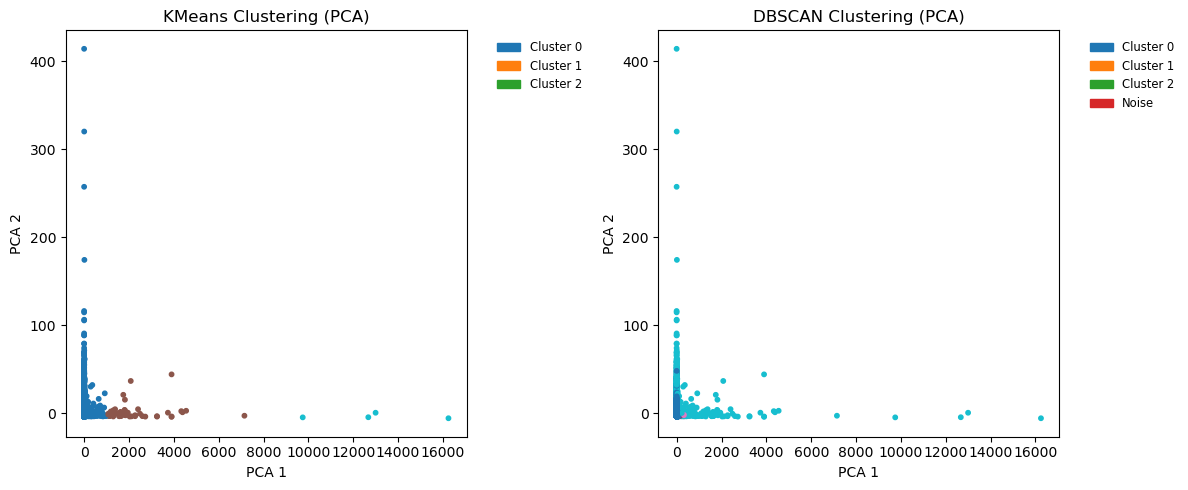

KMeans cluster counts:
0    29939
1       57
2        4
Name: count, dtype: int64
DBSCAN cluster counts (termasuk -1 = noise):
 0    29412
-1      568
 1       11
 2        9
Name: count, dtype: int64


In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

import matplotlib.patches as mpatches

plt.figure(figsize=(12,5))
# KMeans subplot
plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='tab10', s=10)
plt.title('KMeans Clustering (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
# Legend for KMeans
handles = []
unique_k = np.unique(labels_kmeans)
for lab in unique_k:
    handles.append(mpatches.Patch(color=plt.cm.tab10(int(lab) % 10), label=f'Cluster {lab}'))
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)

# DBSCAN subplot
plt.subplot(1,2,2)
if 'labels_dbscan' in globals():
    db_labels = labels_dbscan.copy()
    uniq_db = np.unique(db_labels)
    # Map noise (-1) to a separate integer label for coloring/legend (placed after max cluster)
    if -1 in uniq_db:
        noise_label = uniq_db.max() + 1
        db_plot_labels = np.where(db_labels == -1, noise_label, db_labels)
    else:
        db_plot_labels = db_labels
    plt.scatter(X_pca[:,0], X_pca[:,1], c=db_plot_labels, cmap='tab10', s=10)
    plt.title('DBSCAN Clustering (PCA)')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    # Legend for DBSCAN (with Noise label if present)
    handles = []
    for lab in np.unique(db_plot_labels):
        if 'noise_label' in locals() and lab == noise_label:
            lab_name = 'Noise'
        else:
            lab_name = f'Cluster {int(lab)}'
        handles.append(mpatches.Patch(color=plt.cm.tab10(int(lab) % 10), label=lab_name))
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
else:
    plt.text(0.5, 0.5, 'labels_dbscan not found. Jalankan sel DBSCAN terlebih dahulu.', ha='center')

plt.tight_layout()
plt.show()

# Ringkasan jumlah cluster
print('KMeans cluster counts:')
print(pd.Series(labels_kmeans).value_counts())
print('DBSCAN cluster counts (termasuk -1 = noise):')
print(pd.Series(labels_dbscan).value_counts() if 'labels_dbscan' in globals() else 'labels_dbscan not defined')

### ANN

In [23]:
dim = X_scaled.shape[1]
ann = AnnoyIndex(dim, 'euclidean')
# Build index
for i in range(X_scaled.shape[0]):
    ann.add_item(i, X_scaled[i].astype(float))
ann.build(10)  # 10 trees

# Pilih query point (misal index ke-42)
query_idx = 42 if X_scaled.shape[0] > 42 else 0
print(f'Query Point Index: {query_idx}')
nn, dists = ann.get_nns_by_item(query_idx, 6, include_distances=True)  # 6 termasuk titik itu sendiri
print('Nearest Neighbors and Distances:')
for n, d in zip(nn, dists):
    print(f'Neighbor Index: {n} | Distance: {d:.4f} | Cluster (KMeans): {labels_kmeans[n]} | Cluster (DBSCAN): {labels_dbscan[n]}')

Query Point Index: 42
Nearest Neighbors and Distances:
Neighbor Index: 42 | Distance: 0.0000 | Cluster (KMeans): 0 | Cluster (DBSCAN): 0
Neighbor Index: 3978 | Distance: 0.4048 | Cluster (KMeans): 0 | Cluster (DBSCAN): 0
Neighbor Index: 26622 | Distance: 0.4537 | Cluster (KMeans): 0 | Cluster (DBSCAN): 0
Neighbor Index: 24105 | Distance: 0.4609 | Cluster (KMeans): 0 | Cluster (DBSCAN): 0
Neighbor Index: 29228 | Distance: 0.5133 | Cluster (KMeans): 0 | Cluster (DBSCAN): 0
Neighbor Index: 8350 | Distance: 0.5321 | Cluster (KMeans): 0 | Cluster (DBSCAN): 0


### 7. Tulis kesimpulan singkat:

### 7. Kesimpulan singkat (diisi otomatis)

1) Perbedaan hasil KMeans dan DBSCAN mana yang lebih baik?
- Dalam eksperimen ini KMeans tampak unggul menurut metrik internal.

2) Nilai metrik terbaik (Silhouette, DBI)
- Silhouette (lebih besar lebih baik): KMeans ≈ 0.99120 (tertinggi). DBSCAN terbaik ≈ 0.89924.
- Davies–Bouldin Index (lebih kecil lebih baik): KMeans ≈ 0.34645 (terendah). DBSCAN pada percobaan final ≈ 4.67363.

3) Hasil query Annoy: apakah tetangga yang ditemukan termasuk dalam cluster yang sama?
- Untuk query index = 42, keenam tetangga terdekat yang dikembalikan Annoy (termasuk titik itu sendiri) memiliki assignment cluster yang sama baik menurut KMeans maupun menurut DBSCAN (semua masuk ke cluster 0).